# **import packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn import metrics
import keras
import tensorflow
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.python.client import device_lib

In [2]:
!nvidia-smi

Tue Mar  7 16:35:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   46C    P0    65W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:44:00.0 Off |                    0 |
| N/A   

In [3]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
device_lib.list_local_devices()

2023-03-06 10:36:46.914050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 38284 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-03-06 10:36:46.915920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:1 with 38284 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2023-03-06 10:36:46.917712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:2 with 38284 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2023-03-06 10:36:46.919330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:3 with 38284 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c4:00.0, compute capability: 8.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6462948310197892416,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40144207872
 locality {
   bus_id: 4
   numa_node: 3
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 15397283205426891799
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 40144207872
 locality {
   bus_id: 2
   numa_node: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecuto

# **read data**

In [4]:
input_data=pd.read_csv("flow1.csv",header=0)
data=input_data
input_data.head()
data.shape

(2862119, 2)

# **drop unnecessary columns**

In [5]:
data.drop("Time",axis=1,inplace=True)
data.head()

,v
0,0.008776
1,0.008725
2,0.008660
3,0.008581
4,-0.009265


# **preprocess data**

In [6]:
data_np=np.array(data)
scaler = MinMaxScaler()
scaler.fit(data_np)
all_data_normalized=scaler.transform(data_np)

#drop label
lbl_normalized=all_data_normalized[:,-1]
data_normalized=all_data_normalized

print("label shape",lbl_normalized.shape)
print("data shape",data_normalized.shape)

label shape (2862119,)
data shape (2862119, 1)


In [7]:
data_normalized

array([[0.51038549],
       [0.51033829],
       [0.51027844],
       ...,
       [0.45053204],
       [0.45108378],
       [0.45159611]])

# **create  time series data**

In [8]:
window_size= 30
nfeature=data_normalized.shape[1]

X=[]
y=[]
for i in range(len(data_normalized)-window_size):
    t=[]
    for j in range(0,window_size):
        t.append(data_normalized[[(i+j)], :])
    X.append(t)
    y.append(lbl_normalized[i+ window_size])


data_time_window, lbl_time_window= np.array(X), np.array(y)
data_time_window= data_time_window.reshape(data_time_window.shape[0],window_size, nfeature)
print(data_time_window.shape)
print(lbl_time_window.shape)

(2862089, 30, 1)
(2862089,)


In [9]:
data_time_window[1:10]

array([[[0.51033829],
        [0.51027844],
        [0.51020658],
        [0.49385009],
        [0.49387301],
        [0.49387567],
        [0.49386998],
        [0.49385156],
        [0.49381957],
        [0.49377448],
        [0.49372307],
        [0.49366313],
        [0.49359631],
        [0.49352171],
        [0.49340586],
        [0.49328305],
        [0.49313897],
        [0.49299966],
        [0.49286677],
        [0.49274212],
        [0.49262664],
        [0.49252399],
        [0.49243967],
        [0.49238285],
        [0.49235077],
        [0.49227286],
        [0.49220504],
        [0.49216563],
        [0.4921473 ],
        [0.49216105]],

       [[0.51027844],
        [0.51020658],
        [0.49385009],
        [0.49387301],
        [0.49387567],
        [0.49386998],
        [0.49385156],
        [0.49381957],
        [0.49377448],
        [0.49372307],
        [0.49366313],
        [0.49359631],
        [0.49352171],
        [0.49340586],
        [0.49328305],
        

In [10]:
lbl_time_window[1:10]

array([0.49219954, 0.4922637 , 0.49235077, 0.49247083, 0.49261106,
       0.49273387, 0.49285668, 0.49300608, 0.49318269])

# **split data into train and test sets**

In [11]:
#split data to train and test sets
train_idx= round(.8 * (data_time_window.shape[0]))
train_data=data_time_window[:train_idx,:]
train_lbl=lbl_time_window[:train_idx]
test_data=data_time_window[train_idx:,:]
test_lbl=lbl_time_window[train_idx:]

In [12]:
# activate below command when use 1 gpu
#strategy = tensorflow.distribute.MirroredStrategy(["/gpu:0"])
# activate below command when use 2 gpus
#strategy = tensorflow.distribute.MirroredStrategy(["/gpu:0","/gpu:1"])
# activate below command when use 3 gpus
#strategy = tensorflow.distribute.MirroredStrategy(["/gpu:0","/gpu:1","/gpu:2"])
# activate below command when use 4 gpus
#strategy = tensorflow.distribute.MirroredStrategy(["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])

2023-03-07 16:43:49.247886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38284 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-03-07 16:43:49.250220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38284 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2023-03-07 16:43:49.251827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38284 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2023-03-07 16:43:49.253530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38284 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [14]:
my_epoch=50
#activate below command when run without GPUs (default of the code)
my_batch_size=64
#activate below command when run with GPUs
#my_batch_size=64 * strategy.num_replicas_in_sync

LSTM MODEL

In [15]:
with strategy.scope():
    lstm_win_model = keras.models.Sequential()
    lstm_win_model.add(keras.layers.LSTM(units=100, input_shape=(data_time_window.shape[1],nfeature)))
    lstm_win_model.add(keras.layers.Dense(units=1 ))
    lstm_win_model.compile(optimizer="Adam",loss=keras.losses.mean_squared_error,metrics=tensorflow.metrics.MeanAbsoluteError())
    lstm_win_model.summary()
    keras.utils.vis_utils.plot_model(lstm_win_model)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [16]:
import time
startTime = time.time()

lstm_win_model_hist=lstm_win_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=my_batch_size)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

2022-11-14 02:49:52.000657: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_833"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoSh

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1


2022-11-14 02:50:02.456070: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-11-14 02:50:03.452619: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-11-14 02:50:03.590228: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-14 02:50:04.396170: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-11-14 02:50:04.881728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301


196/196 [==============================] - 15s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0521
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0383
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0374
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0362
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0024 - mean_absolute_error: 0.0349
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0340
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0339
Epoch 8/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0021 - mean_absolute_error: 0.0334
Epoch 9/50
196/196 [==============================] - 1s 5ms/step - loss: 0.0021 - mean_absolute_error: 0.0334
Epoch 10/50

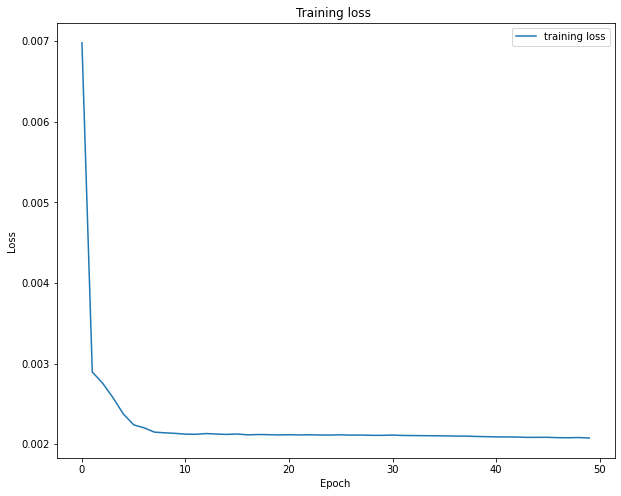

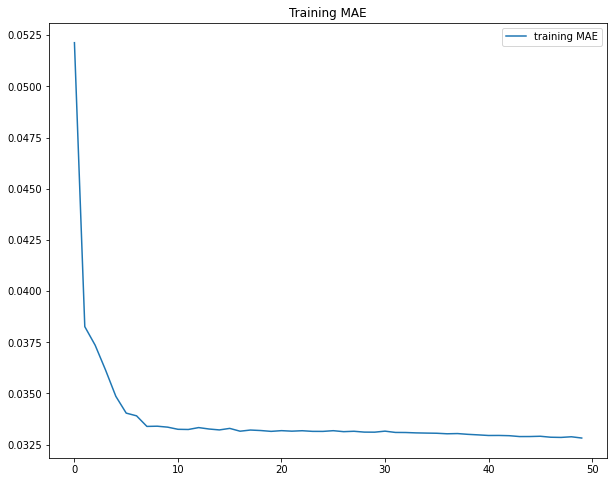

In [17]:
MAE = lstm_win_model_hist.history['mean_absolute_error']
loss = lstm_win_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('Training_loss_LSTM.png')
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.savefig('Training_MAE_LSTM.png')
plt.show()

In [20]:
y_pred_lstm_win=lstm_win_model.predict(test_data,verbose=2)
train_pred_lstm_win=lstm_win_model.predict(train_data,verbose=2)
mse=metrics.mean_squared_error(test_lbl, y_pred_lstm_win)
rmse=metrics.mean_squared_error(test_lbl, y_pred_lstm_win,squared=False)
mae= metrics.mean_absolute_error(test_lbl,y_pred_lstm_win)
Rep = open("error_report_LSTM.txt", "w+")
Rep.write('Mean squared error (MSE): %.3f ' % mse)  
Rep.write('Root mean square error (RMSE) : %.3f '%rmse) 
Rep.write('Mean Absolute Error (MAE): %.3f'%mae)
Rep.write('R2 Score: %.9f ' %r2_score(test_lbl,y_pred_lstm_win))
Rep.close()
print('Mean squared error (MSE): %.3f ' % mse)  
print('Root mean square error (RMSE) : %.3f '%rmse) 
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score",r2_score(test_lbl,y_pred_lstm_win))

2022-11-14 02:53:55.555284: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_97799"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

6250/6250 - 12s


2022-11-14 02:54:08.163886: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_104315"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

25000/25000 - 49s
Mean squared error (MSE): 0.002 
Root mean square error (RMSE) : 0.049 
Mean Absolute Error (MAE): 0.036
R2 Score 0.5676417087995085
